In [1]:
import torch, torchvision
from torch import optim
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay

In [2]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [3]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
])

In [4]:
test_dataset = ImageFolder('intel\seg_test\seg_test', transform=transform_)
val_dataset = ImageFolder('intel\seg_pred', transform=transform_)
train_dataset = ImageFolder('intel\seg_train\seg_train', transform=transform_)

In [5]:
classes = train_dataset.classes
train_batch_size = 8
test_batch_size = 8
num_workers = 2

In [6]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

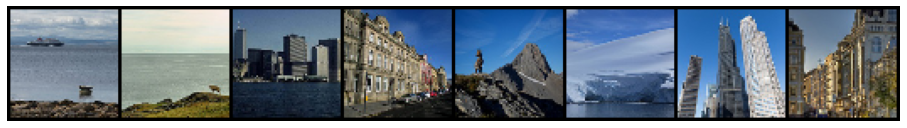

In [7]:
for batch in train_loader:
    plt.figure(figsize=(16, 8))
    image, _ = batch
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [8]:
class ConvNet(nn.Module):
  def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=(1,1))
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1))
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1))
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=(1,1))
      self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=(1,1))
      self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=(1,1))
      self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=(1,1))
      self.conv8 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3), padding=(1,1))
      self.conv9 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3,3), padding=(1,1))
    
      self.pool = nn.MaxPool2d(2,2)
      self.fc1 = nn.Linear(in_features=8*8*1024, out_features=512)
      self.fc2 = nn.Linear(in_features=512, out_features=64)
      self.Dropout = nn.Dropout(0.25)
      self.fc3 = nn.Linear(in_features=64, out_features=6)

  def forward(self, x):
      x = F.relu(self.conv1(x)) #32*32*32
      x = F.relu(self.conv2(x)) #32*32*64
      x = F.relu(self.conv3(x)) #32*32*64
      x = self.pool(x) #16*16*64
      x = F.relu(self.conv4(x)) #16*16*128
      x = F.relu(self.conv5(x)) #16*16*256
      x = F.relu(self.conv6(x)) #16*16*256
      x = self.pool(x) #8*8*256
      x = F.relu(self.conv7(x)) #8*8*512
      x = F.relu(self.conv8(x)) #8*8*1024
      x = F.relu(self.conv9(x)) #8*8*1024
      x = self.pool(x) #4*4*1024
      x = x.view(-1, 8*8*1024) # reshape x
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [9]:
model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (Dropout): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64,

In [10]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}

def fit(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, 
                        "val_loss": val['val_loss'], 
                        "val_acc": val['val_acc']
                       })
    return history

In [11]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

In [12]:
model = model.to(device)
train_loaded = DeviceDataLoader(train_loader, device)
test_loaded = DeviceDataLoader(test_loader, device)

In [13]:
torch.cuda.empty_cache()

In [14]:
''' The bottom code will only work if GPU has a lot of memory (this gives accuracy of around 10%)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 10
history = fit(train_loaded, test_loaded, epochs, optimizer, loss_fn, model)

train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

epoch = np.arange(10)
plt.plot(epoch, val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');
'''

" The bottom code will only work if GPU has a lot of memory (this gives accuracy of around 10%)\nloss_fn = nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.01)\nepochs = 10\nhistory = fit(train_loaded, test_loaded, epochs, optimizer, loss_fn, model)\n\ntrain_loss = [x['loss'] for x in history]\nval_loss = [x['val_loss'] for x in history]\nval_acc = [x['val_acc'] for x in history]\ntrain_loss = [x.item() for x in train_loss]\nval_loss = [x.item() for x in val_loss]\nval_acc = [x.item() for x in val_acc]\n\nepoch = np.arange(10)\nplt.plot(epoch, val_acc)\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.title('Training Accuracy');\n"

In [15]:
torch.cuda.empty_cache()

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10
history = fit(train_loaded, test_loaded, epochs, optimizer, loss_fn, model)

Epoch [0/10] => loss: 0.47833430767059326, val_loss: 0.929095447063446, val_acc: 0.625
Epoch [1/10] => loss: 1.4603551626205444, val_loss: 0.4717732071876526, val_acc: 0.875
Epoch [2/10] => loss: 0.02472849003970623, val_loss: 0.7686964273452759, val_acc: 0.75
Epoch [3/10] => loss: 0.2078607678413391, val_loss: 0.22519256174564362, val_acc: 1.0
Epoch [4/10] => loss: 0.875109076499939, val_loss: 1.4757804870605469, val_acc: 0.5
Epoch [5/10] => loss: 0.5096789002418518, val_loss: 0.663516104221344, val_acc: 0.625
Epoch [6/10] => loss: 0.2084023654460907, val_loss: 0.6665334701538086, val_acc: 0.75
Epoch [7/10] => loss: 0.10521025955677032, val_loss: 0.06401905417442322, val_acc: 1.0
Epoch [8/10] => loss: 0.019840139895677567, val_loss: 0.19494402408599854, val_acc: 0.875
Epoch [9/10] => loss: 0.7286755442619324, val_loss: 0.29326099157333374, val_acc: 0.875


In [21]:
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

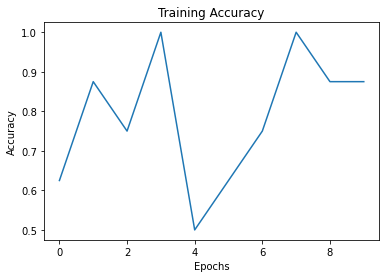

In [22]:
epoch = np.arange(10)
plt.plot(epoch, val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [19]:
import os
prediction_data = []
for i in os.listdir('intel/seg_pred/seg_pred'):
    img = plt.imread('intel/seg_pred/seg_pred/' + i)
    prediction_data.append(transform_(img))

D:\Software\Anaconda\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [25]:
pred_loader = DataLoader(prediction_data, batch_size=8, pin_memory=True, num_workers=2)
pred_loader = DeviceDataLoader(pred_loader, device)

prediction = []
for img in pred_loader:
    out = model(img)
    _, pred = torch.max(out, dim=1)
    prediction.append(pred.to('cpu').numpy())
    break
    
classes_pred = [classes[x] for x in prediction[0]] 

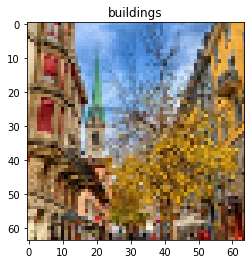

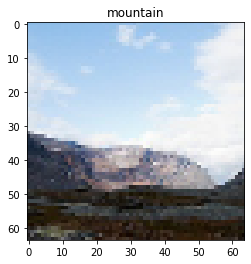

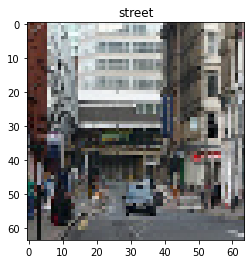

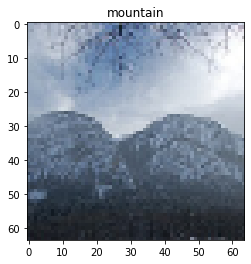

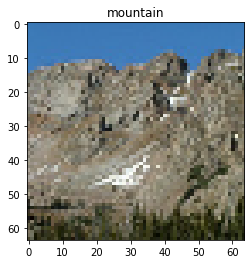

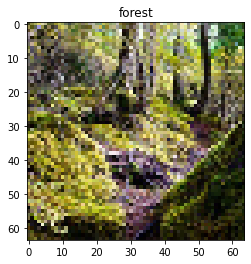

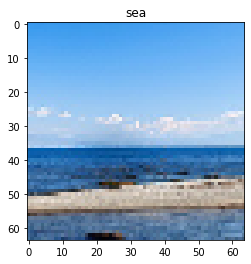

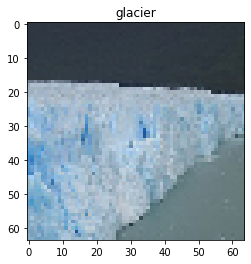

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [26]:
for img in pred_loader:
    for i in range(0, 10):
        plt.imshow(img[i].to('cpu').permute(1, 2, 0))
        plt.title(classes_pred[i])
        plt.show()
    break